### Clinical Drift Detection

In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import pickle
import matplotlib.pyplot as plt

sys.path.append("../..")

from gemini.constants import *
from gemini.utils import *
from drift_detector.plotter import plot_drift_samples_pval, errorfill, linestyles, markers, colors, brightness, colorscale
from drift_detector.utils import scale
from drift_detector.detector import Detector
from drift_detector.reductor import Reductor
from drift_detector.tester import TSTester, DCTester
from drift_detector.experimenter import Experimenter
from drift_detector.clinical_applicator import ClinicalShiftApplicator

2022-10-10 12:15:02,150 INFO cyclops.orm     - Database setup, ready to run queries!


## Config Parameters ##

In [8]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW", "PMH","SBK"]
TIMESTEPS = 6
AGGREGATION_TYPE = "time"
ACADEMIC=["MSH","PMH", "SMH","UHNTW","UHNTG","PMH","SBK"]
COMMUNITY=["THPC","THPM"]

if AGGREGATION_TYPE == "time":
    CONTEXT_TYPE="lstm"
    REPRESENTATION="lstm"
else:
    CONTEXT_TYPE="ffnn"
    REPRESENTATION="rf"
    
OUTCOME = input("Select outcome variable: ") 
SHIFT = input("Select experiment: ")  
MODEL_PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/saved_models/"+SHIFT+"_lstm.pt"

if SHIFT == "simulated_deployment":
    exp_params = {
        'source': [datetime.date(2015, 1, 1),datetime.date(2019, 1, 1)],
        'target': [datetime.date(2019, 1, 1), datetime.date(2020, 8, 1)],
        'shift_type': "source_target"
    }
    
if SHIFT == "covid":
    exp_params = {
        'source': [datetime.date(2019, 1, 1), datetime.date(2020, 2, 1)],
        'target': [datetime.date(2020, 3, 1), datetime.date(2020, 8, 1)],
        'shift_type': "time"
    }

if SHIFT == "seasonal_summer":
    exp_params = {
        'source': [1,2,3,4,5,10,11,12],
        'target': [6,7,8,9],
        'shift_type': "month"
    }

if SHIFT == "seasonal_winter":
    exp_params = {
        'source': [3,4,5,6,7,8,9,10],
        'target': [11,12,1,2],
        'shift_type': "month"
    }
    
if SHIFT == "hosp_type_academic":
    exp_params = {
        'source': ACADEMIC, 
        'target': COMMUNITY,
        'shift_type':"hospital_type"
    }

if SHIFT == "hosp_type_community":
    exp_params = {
        'source':COMMUNITY, 
        'target': ACADEMIC,
        'shift_type':"hospital_type"
    }

Select outcome variable:  mortality
Select experiment:  hosp_type_community


## Query Data ##

In [9]:
admin_data, x, y = get_gemini_data(PATH)

# y_tr, y_val, y_t are not used, X_tr is used for fitting PCA, X_val, X_t are not used. (overwritten by clinicalshift produced from x)
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITALS)

# used in clinicalshiftapplicator to produce X_val and X_t (ex., )
x = x.loc[~x.index.get_level_values(0).isin(X_tr.index.get_level_values(0))]

# Normalize training data
X_tr_normalized  = normalize(admin_data, X_tr, AGGREGATION_TYPE, TIMESTEPS)
if AGGREGATION_TYPE != "time":
    y_tr = get_label(admin_data, X_tr, OUTCOME)
# Scale training data
X_tr_scaled = scale(X_tr_normalized)
# Process training data
X_tr_final = process(X_tr_scaled, AGGREGATION_TYPE, TIMESTEPS)

2022-10-10 12:21:30,672 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-10-10 12:21:31,962 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-10-10 12:21:32,445 INFO cyclops.feature_handler - Loading features from file...
2022-10-10 12:21:32,461 INFO cyclops.feature_handler - Found file to load for static features...
2022-10-10 12:21:32,465 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-10-10 12:21:32,551 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-10-10 12:21:50,153 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-10-10 12:22:22,084 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


## Reductor

In [15]:
DR_TECHNIQUE = input("Select dimensionality reduction technique: ")

reductor = Reductor(
    dr_method = DR_TECHNIQUE,
    model_path = MODEL_PATH,
    n_features = len(feats),
    var_ret = 0.8,
)

Select dimensionality reduction technique:  BBSDs_untrained_FFNN


## Two Sample Tester

In [16]:
TS_TEST = input("Select test method: ")

tester = TSTester(
    tester_method=TS_TEST,
)

Select test method:  mmd


## Domain Classifier Tester

In [ ]:
DC_TEST = input("Select test method: ")

tester = DCTester(
    tester_method=DC_TEST,
)

## Detector

In [17]:
detector = Detector(
    reductor = reductor,
    tester = tester,
    p_val_threshold = 0.05
    
)
detector.fit(
    X_tr_final,
    model_path = MODEL_PATH,
    context_type=CONTEXT_TYPE
    )

## ClinicalShiftApplicator

In [18]:
clinicalshiftapplicator = ClinicalShiftApplicator(
    shift_type = exp_params['shift_type']
) 

experimenter = Experimenter(
    detector = detector,
    clinicalshiftapplicator = clinicalshiftapplicator,
    admin_data = admin_data
)

## Experimenter

In [19]:
X_val, X_t = experimenter.apply_clinical_shift(
    x,
    source=exp_params['source'],
    target=exp_params['target']
)
# Normalize data
X_val_normalized = normalize(admin_data, X_val, AGGREGATION_TYPE, TIMESTEPS)
X_t_normalized = normalize(admin_data, X_t, AGGREGATION_TYPE, TIMESTEPS)

if AGGREGATION_TYPE != "time":
    y_val = get_label(admin_data, X_val, OUTCOME)
    y_t = get_label(admin_data, X_t, OUTCOME)
    
# Scale data
X_val_scaled = scale(X_val_normalized)
X_t_scaled = scale(X_t_normalized)

# Process data
X_val_final = process(X_val_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_t_final = process(X_t_scaled, AGGREGATION_TYPE, TIMESTEPS)

val_drift_results = experimenter.detect_shift_samples(
    X_val_final,
    model_path = MODEL_PATH,
    context_type=CONTEXT_TYPE,
    n_permutations= 100
)
test_drift_results = experimenter.detect_shift_samples(
    X_t_final,
    model_path = MODEL_PATH,
    context_type=CONTEXT_TYPE
)
shift_results = {
    'baseline': val_drift_results,
    'experiment': test_drift_results
}

100%|██████████| 35/35 [24:05<00:00, 41.29s/it]


## Plot drift results

### In hospital mortality (Academic --> Community): BBSDs_untrained_FFNN + MMD

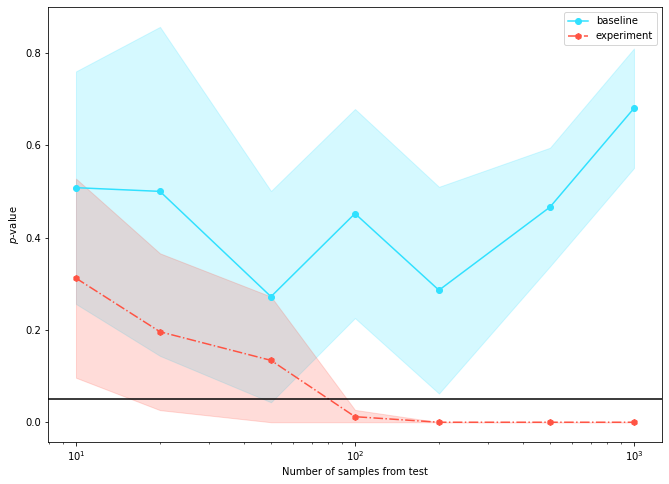

In [17]:
plot_drift_samples_pval(shift_results, 0.05)

### In hospital mortality (Community --> Academic): BBSDs_untrained_FFNN + MMD

In [ ]:
plot_drift_samples_pval(shift_results, 0.05)

### Mortality decompensation (Community --> Academic): BBSDs_untrained_FFNN + MMD

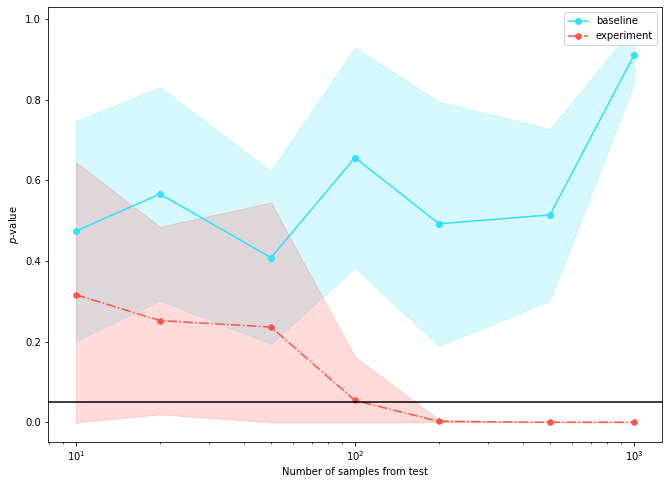

In [20]:
plot_drift_samples_pval(shift_results, 0.05)

### Mortality decompensation (Community --> Academic): BBSDs_trained_LSTM + MMD

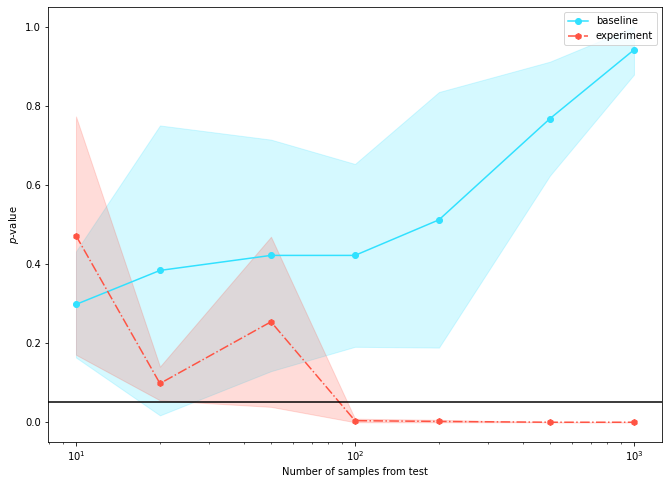

In [27]:
plot_drift_samples_pval(shift_results, 0.05)

### Mortality decompensation (Academic --> Community): BBSDs_trained_LSTM + MMD

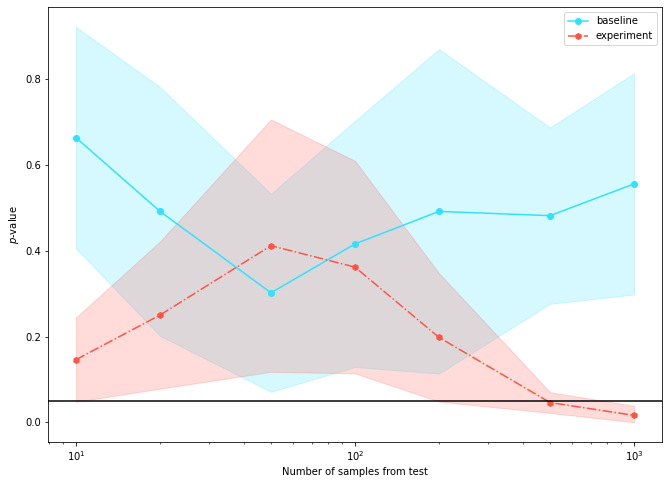

In [ ]:
plot_drift_samples_pval(shift_results, 0.05)